# Recommendation Systems for Speedrun.com

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict, Counter
from operator import itemgetter
from sklearn.model_selection import train_test_split

# Exploratory Analysis

In [3]:
user_prefs_df = pd.read_csv('../data/raw/srcom_users_with_metadata.csv')
user_prefs_df = user_prefs_df[(user_prefs_df['signup_date'].notna()) & (user_prefs_df['signup_date'] != "Null")]
user_prefs_df['signup_date'] = pd.to_datetime(user_prefs_df['signup_date'], format='%Y-%m-%dT%H:%M:%SZ')
user_prefs_df['signup_date'] = pd.to_datetime(user_prefs_df['signup_date'].dt.strftime('%Y-%m-%d'))
user_prefs_df = user_prefs_df[(user_prefs_df['signup_date'] < '2023-01-01')]

In [4]:
user_prefs_df.describe(include='all', datetime_is_numeric=True)

,user,signup_date,location,num_games,games
count,335322,335322,335322,335322.000000,335322
unique,335322,NaN,257,NaN,88806
top,j5wzz2qj,NaN,us,NaN,k6q4rqzd
freq,1,NaN,101439,NaN,5131
mean,NaN,2020-06-28 13:40:53.271780608,NaN,1.994465,NaN
min,NaN,2014-01-06 00:00:00,NaN,1.000000,NaN
25%,NaN,2019-09-16 00:00:00,NaN,1.000000,NaN
50%,NaN,2021-01-04 00:00:00,NaN,1.000000,NaN
75%,NaN,2021-09-25 00:00:00,NaN,2.000000,NaN
max,NaN,2022-12-31 00:00:00,NaN,2059.000000,NaN


In [5]:
exploded_games_df = user_prefs_df.copy()
exploded_games_df['games'] = exploded_games_df['games'].str.split(',')
exploded_games_df = exploded_games_df.explode('games').rename(columns = {'games': 'game_id', 'user':'user_id'})[['user_id', 'game_id']]

In [6]:
exploded_games_df.describe()

,user_id,game_id
count,668788,668788
unique,335322,31425
top,kj9521v8,k6q4rqzd
freq,2059,6979


In [7]:
bipartite_graph = nx.Graph()

# Users have a bipartite value of 0, games have a bipartite value of 1.
bipartite_graph.add_nodes_from(set(exploded_games_df['user_id'].values), bipartite=0)
bipartite_graph.add_nodes_from(set(exploded_games_df['game_id'].values), bipartite=1)
bipartite_graph.add_edges_from([(user, game) for user, game in zip(exploded_games_df['user_id'], exploded_games_df['game_id'])])

In [8]:
nx.is_bipartite(bipartite_graph)

True

In [9]:
del user_prefs_df, exploded_games_df

# Overlapping Set Similarity with Limiting the Graph

There are two methods of limiting the number of user-item interactions in our bipartite graph. We can either use the mean and standard deviation of the `num_games` column, or limit based on the integer number of games played by a given user. For example, we can either use three standard deviations of the mean to have a cutoff value of `24.2 (3 s.f.)`, or we can use the value of `2` for users that have played only one game.

Using the method of standard deviations, we get a very similar output to the unlimited user-item interaction bipartite graph. We get popular games recommended most of the time. If we use the second approach, we get (anecdotally) more precise recommendations. However, the second method does not scale well, since we need to construct a different graph for each number of games played by each user. In reality, this isn't as bad as we think. Out of the 335,322 total users in our sample we can cover 306,371 users, or 91.4% (3 s.f.) of them with three graphs. 

In [2]:
def clean_user_preferences_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df[(df['signup_date'].notna()) & (df['signup_date'] != "Null")]
    df['signup_date'] = pd.to_datetime(df['signup_date'], format='%Y-%m-%dT%H:%M:%SZ')
    df['signup_date'] = pd.to_datetime(df['signup_date'].dt.strftime('%Y-%m-%d'))
    df = df[(df['signup_date'] < '2023-01-01')]
    return df

def limit_number_games_user_preferences_df(df: pd.DataFrame, num_games: int) -> pd.DataFrame:
    return df[(df['num_games'] <= num_games)]

def explode_games_played(df: pd.DataFrame) -> pd.DataFrame:
    df['games'] = df['games'].str.split(',')
    return df.explode('games').rename(columns = {'games': 'game_id', 'user':'user_id'})

def recommendation_graph_for_n_games_played(df: pd.DataFrame, n: int) -> tuple[pd.DataFrame, nx.Graph]:
    df = clean_user_preferences_df(df)
    df = limit_number_games_user_preferences_df(df, n+1)
    df = explode_games_played(df)
    bipartite_graph = nx.Graph()
    bipartite_graph.add_nodes_from(set(df['user_id'].values), bipartite=0)
    bipartite_graph.add_nodes_from(set(df['game_id'].values), bipartite=1)
    bipartite_graph.add_edges_from([(user, game) for user, game in zip(df['user_id'], df['game_id'])])
    return df, bipartite_graph

In [3]:
user_prefs_df = pd.read_csv('../data/raw/srcom_users_with_metadata.csv')
user_prefs_df, bipartite_graph = recommendation_graph_for_n_games_played(user_prefs_df, 5)

/var/folders/fp/pwtrzcy130zdfcx62mp9_kmc0000gn/T/ipykernel_4884/4036755379.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signup_date'] = pd.to_datetime(df['signup_date'], format='%Y-%m-%dT%H:%M:%SZ')
/var/folders/fp/pwtrzcy130zdfcx62mp9_kmc0000gn/T/ipykernel_4884/4036755379.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signup_date'] = pd.to_datetime(df['signup_date'].dt.strftime('%Y-%m-%d'))


In [12]:
def user_similarity(bipartite_graph: nx.Graph, total_item_nodes: int, user_a_id: str, user_b_id: str) -> float:
    assert bipartite_graph.nodes[user_a_id]['bipartite'] == 0
    assert bipartite_graph.nodes[user_b_id]['bipartite'] == 0

    a_neighbours = bipartite_graph.neighbors(user_a_id)
    b_neighbours = bipartite_graph.neighbors(user_b_id)
    shared_nodes = set(a_neighbours).intersection(b_neighbours)

    return len(shared_nodes) / total_item_nodes

def most_similar_users(bipartite_graph: nx.Graph, user_id: str) -> tuple[list[str], float]:
    all_users = set([user for user, value in bipartite_graph.nodes(data=True) if value['bipartite'] == 0])
    all_users.remove(user_id)

    total_item_nodes = 0
    for _, values in bipartite_graph.nodes(data=True):
        if values['bipartite'] == 1: total_item_nodes += 1

    similarities = defaultdict(float)
    for user in all_users:
        similarities[user] = user_similarity(bipartite_graph, total_item_nodes, user_id, user)

    max_similarity = max(similarities.values())
    return [user for user, similarity in similarities.items() if similarity == max_similarity], max_similarity

def recommend_games(bipartite_graph: nx.Graph, user_id: str) -> list[str]:
    similar_users, _ = most_similar_users(bipartite_graph, user_id)
    other_games = [game for user in similar_users for game in bipartite_graph.neighbors(user)]
    game_rankings = Counter(other_games)

    already_played_games = set(bipartite_graph.neighbors(user_id))

    try:
        [game_rankings.pop(game) for game in already_played_games]
    except KeyError:
        # If no other users in data set have played this game.
        pass

    ranked_games_in_order, _ = list(zip(*sorted(game_rankings.items(), key=itemgetter(1), reverse=True)))
    
    return ranked_games_in_order

In [13]:
games_metadata_df = pd.read_csv('../data/raw/srcom_games_with_metadata.csv').rename(columns={'game_id': 'id'})

In [14]:
user = "x355n6qj"

played_games = list(bipartite_graph.neighbors(user))
print(f"Played games: {games_metadata_df[(games_metadata_df['id'].isin(played_games))].game_name.values}")

recommended_games = recommend_games(bipartite_graph, user)
print(f"Recommended games: {games_metadata_df.set_index('id').loc(axis=0)[recommended_games].game_name.values[:20]}")

Played games: ['Hello Neighbor' 'Super Mario Odyssey']
Recommended games: ["Baldi's Basics Category Extensions" 'Google Quick Draw'
 'Snipperclips: Cut it out  together!' 'Hello Neighbor 2' 'Clicker Heroes'
 'Minecraft: Java Edition' 'Island Saver'
 'Super Mario Odyssey Category Extensions' 'Cuphead'
 'Super Mario Sunshine' 'Marble Saga: Kororinpa'
 'The Legend of Zelda: The Wind Waker HD']


In [15]:
del games_metadata_df, played_games, recommended_games, user_prefs_df, bipartite_graph, user

# Recommendation Using a Game Similarity Matrix

This recommendation method works by creating a matrix of how users have rated different games. We construct this matrix by rating a game `1` if a user has played it, and `0` if not. We then normalise these values by making the sum of ratings by each user equal to `1`. This is also called [scaling to a unit length](https://en.wikipedia.org/wiki/Feature_scaling#Scaling_to_unit_length). We take the dot product of the matrix and the transposed matrix, and this gives us the similarity between each item in the data set. The method is taken from [here](https://towardsdatascience.com/recommender-systems-item-customer-collaborative-filtering-ff0c8f41ae8a). **This method does not scale very well**.

In [4]:
def format_user_prefs_df_to_ratings(df: pd.DataFrame) -> pd.DataFrame:
    tmp_df = df.copy()
    tmp_df['games'] = tmp_df['games'].str.split(',')
    tmp_df = tmp_df.explode('games').rename(columns = {'games': 'game_id', 'user':'user_id'})
    tmp_df['rating'] = 1
    return tmp_df[['user_id', 'game_id', 'rating']]

def construct_similarity_matrix(df: pd.DataFrame) -> pd.DataFrame:
    tmp_df = df.copy()
    tmp_df = pd.pivot_table(tmp_df, values='rating', index='user_id', columns='game_id')
    tmp_df = tmp_df.fillna(0.0)
    normalised_tmp_df = tmp_df / np.sqrt(np.square(tmp_df).sum(axis=0))
    return normalised_tmp_df.transpose().dot(normalised_tmp_df)

def recommend_from_game(similarity_matrix: pd.DataFrame, game_id: str, n_recommendations: int) -> list[str]:
    return similarity_matrix.nlargest(n_recommendations+1, game_id).index.values[1:]

def recommendation_metrics_at_k(test_df: pd.DataFrame, similarity_matrix: pd.DataFrame, k: int) -> tuple[float, float, float]:
    recommendations = []
    unique_games_in_test = np.unique(test_df['games'].str.split(',').apply(pd.Series).stack().reset_index(drop=True))
    for game in unique_games_in_test:
        try:
            game_row = similarity_matrix.loc[game]
            recs = pd.Series(game_row).where(lambda x: x >= 0.1).dropna().sort_values(ascending=False).index.values.tolist()[1:k+1]
            recommendations.extend(recs)
        except KeyError:
            # If no other users in data set have played this game.
            pass

    relevant_games_set = set(unique_games_in_test)
    recommended_games_set = set(recommendations)
    intersection = len(recommended_games_set.intersection(relevant_games_set))
    recall = intersection/len(relevant_games_set)
    precision = intersection/len(recommended_games_set)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return recall, precision, f1_score

In [19]:
user_prefs_df = pd.read_csv('../data/raw/srcom_users_with_metadata.csv').sample(20000, random_state=6)
# user_prefs_df = pd.read_csv('../data/raw/srcom_users_with_metadata.csv').sort_values(by='num_games', ascending=False)[:7000]

train_df, test_df = train_test_split(user_prefs_df, test_size=0.2, random_state=0)

train_df = format_user_prefs_df_to_ratings(train_df)
print(train_df['user_id'].nunique(), train_df['game_id'].nunique())
# similarity_matrix = construct_similarity_matrix(train_df)
# similarity_matrix = pd.read_csv('../../game_similarity_matrix.csv').set_index('game_id')

16000 9650


In [20]:
results_df = pd.DataFrame(columns=['Recall', 'Precision', 'F1-Score'])
for number_k in range(1, 21):
    recall, precision, f1_score = recommendation_metrics_at_k(test_df, similarity_matrix, number_k)
    results_df.loc[number_k] = recall, precision, f1_score
results_df

,Recall,Precision,F1-Score
1,0.271015,0.540530,0.361019
2,0.410347,0.502577,0.451803
3,0.490772,0.475978,0.483262
4,0.544611,0.460686,0.499145
5,0.585636,0.453126,0.510929
6,0.615186,0.446798,0.517642
7,0.641102,0.442100,0.523321
8,0.661949,0.439576,0.528316
9,0.681457,0.438253,0.533443
10,0.697428,0.436628,0.537040


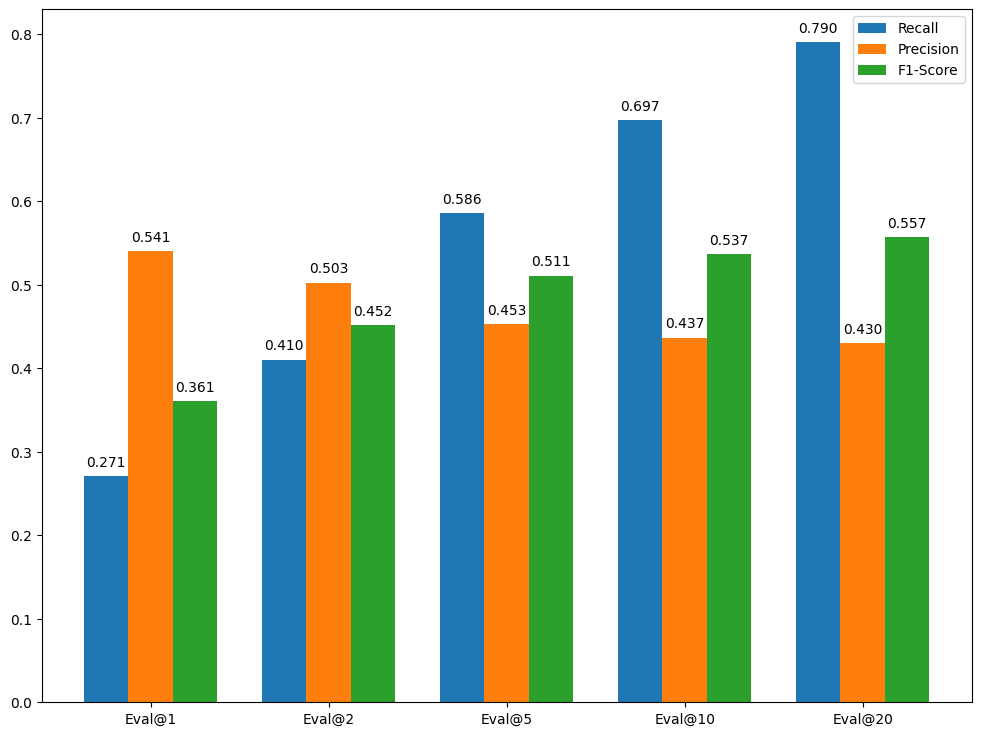

In [21]:
recall = results_df.loc[[1, 2, 5, 10, 20]]['Recall'].values.tolist()
precision = results_df.loc[[1, 2, 5, 10, 20]]['Precision'].values.tolist()
f1_score = results_df.loc[[1, 2, 5, 10, 20]]['F1-Score'].values.tolist()

labels = ['Eval@1', 'Eval@2', 'Eval@5', 'Eval@10', 'Eval@20']
width = 0.25
ind = np.arange(len(labels))

fig, ax = plt.subplots(1, 1)
ax.bar(ind - width, recall, width, label='Recall')
ax.bar(ind, precision, width, label='Precision')
ax.bar(ind + width,f1_score, width, label='F1-Score')
ax.legend(loc='best')
ax.set_xticks(ind, labels)

for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

fig.set_figheight(9)
fig.set_figwidth(12)

plt.show()

In [22]:
games_metadata_df = pd.read_csv('../data/raw/srcom_games_with_metadata.csv').rename(columns={'game_id': 'id'})

In [25]:
game_id = "4pd03wde"
n = 10
recommended_games = recommend_from_game(similarity_matrix, game_id, n)

print(f"Played Game: {games_metadata_df.set_index('id').loc(axis=0)[game_id].game_name}")
print(f"Recommended games: {games_metadata_df.set_index('id').loc(axis=0)[recommended_games].game_name.values}")

Played Game: World of Illusion Starring Mickey Mouse and Donald Duck
Recommended games: ['Castle of Illusion Starring Mickey Mouse (Genesis)'
 'Legend of Illusion starring Mickey Mouse'
 'Castle of Illusion starring Mickey Mouse (SMS)' 'Earnest Evans'
 'Bonanza Bros. (Genesis)' 'ALF' 'Castle of Illusion HD' 'Pocahontas'
 'QuackShot Starring Donald Duck' 'OutRun (Arcade)']


In [18]:
del game_id, n, recommended_games, games_metadata_df, user_prefs_df, train_df, test_df, similarity_matrix, results_df, recall, precision, f1_score, number_k

# Recommendation using Node2Vec Embeddings

The idea behind using node2vec embeddings for recommendation is to predict future links that don't already exist. We can prove that this works for individual games recommendation by removing selected edges and using cosine similarity of embeddings to predict which edges should exist given this graph. We carry this on further by creating a pipeline to predict games to play when they are completely disconnected.

Do [this](https://sparsh-ai.github.io/rec-tutorials/graph%20embedding%20movielens%20factorization/2021/04/24/Recommendation-Node2vec.html)?

This guy ^ goes absolutely fucking crazy. he's got tonnes of stuff. This one looks goated: https://github.com/sparsh-ai?tab=repositories&q=rec-tut&type=&language=&sort=. Specifically the movielens100k dataset, but all of them probably have some really good stuff.

In [216]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, auc, roc_curve, roc_auc_score,confusion_matrix

In [217]:
edge_existence_df = pd.read_csv('../data/games/network/edge_existence_dataset.csv').set_index('index')
embeddings_df = pd.read_csv('../data/games/network/embeddings/test.emb', delimiter=" ", skiprows=1, index_col=0, header=None).rename(columns={0: 'id'}).add_prefix("dim_")

In [218]:
edge_features = [(embeddings_df.loc[node1].values.tolist()+embeddings_df.loc[node2].values.tolist()) for node1, node2 in zip(edge_existence_df["source"], edge_existence_df["target"])]

In [207]:
X = np.array(edge_features)
y = edge_existence_df['connection']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [208]:
X_train.shape, y_train.shape

((10471, 32), (10471,))

In [209]:
clf1 = RandomForestClassifier()
 
# parameters
param = {'n_estimators' : [10,50,100], 'max_depth' : [5,10,15]}
 
# model
grid_clf_acc1 = GridSearchCV(clf1, param_grid = param)
 
# train the model
grid_clf_acc1.fit(X_train, y_train)
 
print('Grid best parameter (max. accuracy): ', grid_clf_acc1.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc1.best_score_)
 
# alternative metric to optimize over grid parameters: AUC
grid_clf_auc1 = GridSearchCV(clf1, param_grid = param, scoring = 'roc_auc')
grid_clf_auc1.fit(X_train, y_train)
predict_proba = grid_clf_auc1.predict_proba(X_test)[:,1]
 
print('Test set AUC: ', roc_auc_score(y_test, predict_proba))
print('Grid best parameter (max. AUC): ', grid_clf_auc1.best_params_)
print('Grid best score (AUC): ', grid_clf_auc1.best_score_)

Grid best parameter (max. accuracy):  {'max_depth': 15, 'n_estimators': 50}
Grid best score (accuracy):  0.9985675631933949
Test set AUC:  0.999998330779426
Grid best parameter (max. AUC):  {'max_depth': 10, 'n_estimators': 50}
Grid best score (AUC):  0.9999765448696089


In [214]:
confusion_matrix(grid_clf_auc1.predict(X_test),y_test)

array([[ 929,    0],
       [  10, 2552]], dtype=int64)

In [ ]:
# Test if there is a link between super mario odyssey and super mario 64 (there is).
# IDs: 76r55vd8 o1y9wo6q
SMO = [0.003971752, 0.00646716, 0.005253054, 0.000770621, 0.023088027, -0.0025586337, 0.021919776, 0.023069408, 0.00055524334, 0.018905181, -0.015266668, -0.0029585548, 0.010636453, -0.017556641, -0.0020937473, -0.029378641, 0.013062697, -0.009451449, -0.020212192, 0.017371856, 0.003602054, -0.026192848, -0.025948, 0.017900482, 0.02082228, -0.019447599, 0.020568952, 0.025263663, -0.01999519, -0.023548912, -0.019287951, -0.011146348]
SM64 = [-0.012588676, -0.029154047, -0.0028756857, -0.009487752, 0.017457027, 0.0210394, -0.010649294, -0.0018646903, 0.022166133, -0.024311021, 0.0062766, -0.029152796, -0.030749485, 0.0017411523, 0.029207725, -0.015724432, 0.009961858, 0.008669887, 0.01067755, -0.012766957, 0.0050436445, -0.0035253912, -0.008545488, -0.022413097, -0.014777329, -0.005886156, -0.024985388, 0.004289292, -0.0025947131, 0.0019044504, -0.014002968, -0.02486419]

smo_sm64_features = np.array(SMO + SM64).reshape(1, -1)
grid_clf_auc1.predict(smo_sm64_features)